# Apply the battery to our data and calculate the cost with and without battery (and logic)

## Ready the dataset
Imports

In [2]:
# Load peak hour price data and meter-id data
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
# Import battery class 
from battery import Battery, Battery2

Load data

In [3]:
# Load production and consumption for the cleaned meters 
df_prod = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-PROD.csv")
df_cons = pd.read_csv("data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED-CONS.csv")

# Load json file hour_lookup_price.json
with open('data/hour_lookup_price_dict.json') as json_file:
    hour_lookup_price = json.load(json_file)


Define get series function

In [4]:
def get_series(meter_id, type="prod", start=None, end=None, agg=None):
    """Create Series from meter_id and type of data

    Args:
        meter_id (str): meter-id
        type (str, optional): production or consumption of kwh. Defaults to "prod".
        start (str, optional): timeslot to start series. Defaults to None.
        end (str, optional): timeslot to end series. Defaults to None.
        agg (str, optional): aggregation of data. One of day, week or month. Defaults to None.

    Returns:
        pd.series: series of filtered data
    """

    print("Getting series for meter_id: {}".format(meter_id))

    # if start not none
    if start is not None:
        # Convert to datetime
        start = pd.to_datetime(start)
    
    # if end not none
    if end is not None:
        # Convert to datetime
        end = pd.to_datetime(end)

    if type == "prod":
        df_return = df_prod[df_prod["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    elif type == "cons":
        df_return = df_cons[df_cons["meter_id"] == meter_id]
        # Drop all columns but timeslot and num_kwh_normalized
        df_return = df_return[['timeslot', 'num_kwh']]
        # Set index to timeslot
        # Filter on start and end
        # Convert timeslot to datetime
        df_return["timeslot"] = pd.to_datetime(df_return["timeslot"], utc=True)
        if start is not None and end is not None:
            print("Filtering on start and end: ", start, end)
            try:
                df_return = df_return[(df_return['timeslot'] >= start) & (df_return['timeslot'] <= end)]
            except Exception as e:
                print(e)
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                print("Format for input end: ", end)
                pass
        elif start is not None:
            print("Filtering on start: ", start)
            try:
                df_return = df_return[(df_return['timeslot'] >= start)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input start: ", start)
                pass
        elif end is not None:
            print("Filtering on end: ", end)
            try:
                df_return = df_return[(df_return['timeslot'] <= end)]
            except:
                print("No data for this timeslot, timeslot might be incorrect format or out of range:")
                print("Format and range for timeslot: ", df_return.index[0], " ", df_return.index[-1])
                print("Format for input end: ", end)
                pass

    df_return = df_return.set_index("timeslot").sort_index()

    # If agg is not none
    if agg is not None:
        if agg == "day":
            df_return = df_return.resample("D").sum()
        elif agg == "week":
            df_return = df_return.resample("W").sum()
        elif agg == "month":
            df_return = df_return.resample("M").sum()
        else:
            print("Aggregation not supported")
            return None

    # Return series
    return df_return

Extract specific meter from data

In [5]:
# Choose the meter id with the most observations
# meter_id = "28ba7f57-6e83-4341-8078-232c1639e4e3"
# meter_id = "d0e900eb-23ec-4449-8d92-4ddb4da657ee"
meter_id = "e882f9a7-f1de-4419-9869-7339be303281"

series_prod = get_series(meter_id, "prod", start="2016-09-04 22:00:00+00:00", end = "2019-05-14 21:00:00+00:00")
series_cons = get_series(meter_id, "cons", start="2016-09-04 22:00:00+00:00", end = "2019-05-14 21:00:00+00:00")

Getting series for meter_id: e882f9a7-f1de-4419-9869-7339be303281
Filtering on start and end:  2016-09-04 22:00:00+00:00 2019-05-14 21:00:00+00:00
Getting series for meter_id: e882f9a7-f1de-4419-9869-7339be303281
Filtering on start and end:  2016-09-04 22:00:00+00:00 2019-05-14 21:00:00+00:00


Merge consumption and production into one dataset

In [6]:
# Merge series
series_merge = pd.merge(series_prod, series_cons, how="outer", left_index=True, right_index=True)
# Rename num_kwh_normalized_x and num_kwh_normalized_y
series_merge.columns = ["num_kwh_prod", "num_kwh_cons"]

# Add column called power_yield with the difference between prod and cons
series_merge["power_yield"] = series_merge["num_kwh_prod"] - series_merge["num_kwh_cons"]
# add column current index as timeslot and reset index
series_merge["timeslot"] = series_merge.index
series_merge = series_merge.reset_index(drop=True)

series_merge.head()

,num_kwh_prod,num_kwh_cons,power_yield,timeslot
0,0.0,1.0,-1.0,2016-11-14 23:00:00+00:00
1,0.0,3.0,-3.0,2016-11-15 00:00:00+00:00
2,0.0,2.0,-2.0,2016-11-15 01:00:00+00:00
3,0.0,2.0,-2.0,2016-11-15 02:00:00+00:00
4,0.0,1.0,-1.0,2016-11-15 03:00:00+00:00


Calculate the sum of consumption and production and the number of panels connected to the meter

In [7]:
print("Summed production: ", series_merge[series_merge["power_yield"] > 0]["power_yield"].sum())
print("Summed consumption: ", series_merge[series_merge["power_yield"] < 0]["power_yield"].sum())

print()
print("Number of panels for meter: ", df_prod[df_prod["meter_id"] == meter_id]["num_panels"].iloc[0])

Summed production:  9783.587
Summed consumption:  -45332.447

Number of panels for meter:  43.0


## Plot
Define moving average function

In [8]:
def moving_average(timeseries, window):
    """Calculate the moving average of a timeseries.

    Args:
        timeseries (pd.Series): timeseries
        window (int): Window size

    Returns:
        pd.Series: Smoothened timeseries
    """
    return timeseries.rolling(window=window, center=True).mean()

Calculate moving average

In [9]:
window_size = 24*31

series_merge["num_kwh_cons_ma"] = moving_average(series_merge["num_kwh_cons"], window=window_size)
series_merge["num_kwh_prod_ma"] = moving_average(series_merge["num_kwh_prod"], window=window_size)

Plot consumption and production

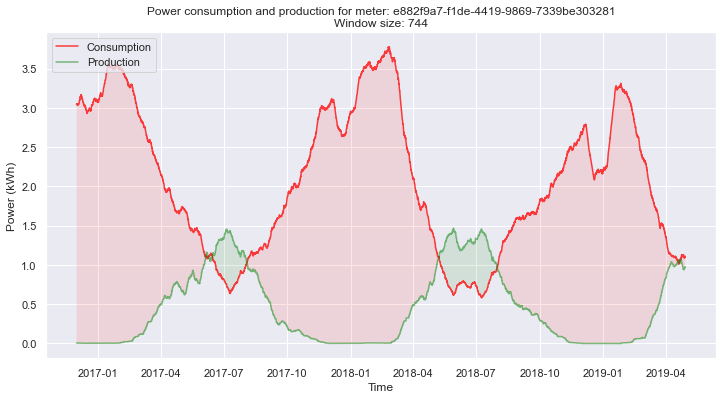

In [10]:
# num_kwh_cons_ma = moving_average(series_merge["num_kwh_cons"], window=24)
sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_merge["timeslot"], series_merge["num_kwh_cons_ma"], label="Consumption", color="red", alpha=0.75)
ax.plot(series_merge["timeslot"], series_merge["num_kwh_prod_ma"], label="Production", color="green", alpha=0.5)
# ax.plot(series_battery["timeslot"], series_battery["surplus_deficit"], label="Surplus Deficit", alpha=0.75)
# show legend
ax.legend(loc="upper left")

# Fill between positive
# ax.fill_between(series_merge["timeslot"], 0, series_merge["num_kwh_cons_ma"], where=series_merge["num_kwh_cons_ma"] >= 0, facecolor="green", alpha=0.5)
ax.fill_between(series_merge["timeslot"], series_merge["num_kwh_cons_ma"], series_merge["num_kwh_prod_ma"], where=series_merge["num_kwh_prod_ma"]>series_merge["num_kwh_cons_ma"], facecolor='green', alpha=0.1)
ax.fill_between(series_merge["timeslot"], series_merge["num_kwh_cons_ma"], series_merge["num_kwh_prod_ma"], where=series_merge["num_kwh_prod_ma"]<series_merge["num_kwh_cons_ma"], facecolor='red', alpha=0.1)

# x-axis label
ax.set_xlabel("Time")
# y-axis label
ax.set_ylabel("Power (kWh)")

# plot title    
ax.set_title("Power consumption and production for meter: " + meter_id + "\nWindow size: " + str(window_size))

plt.show()

## Battery logic rollout
Define peak hours

In [11]:
# Define peak hours 
peak_hours = list(range(6,19))

Define logic/policy rollout, price, and price summary functions

In [12]:
# Load json file hour_lookup_price.json
with open('data/hour_lookup_price_dict.json') as json_file:
    hour_lookup_price = json.load(json_file)

def logic_rollout(series_battery, battery, logic, get_price):
    """Battery logic rollout

    Args:
        series_battery (DataFrame): time series of battery
        battery (object): Battery object 
        logic (funct): Logic function applied to the row
        get_price (funct): Get price function

    Returns:
        DataFrame: Time series datafram with applied logic and price
    """
    series_battery = series_battery.apply(lambda row: logic(row, battery), axis=1)
    series_battery["price"] = series_battery.apply(lambda row: get_price(row["surplus_deficit"], row["timeslot"]), axis=1)
    series_battery["price_cummulative"] = series_battery["price"].cumsum(axis=0)
    return series_battery


# Definge get price function   
def get_price(demand, timestamp):
    """Get price function

    Args:
        demand (float): Power demand
        hour (int): Hour of the day to make price lookup

    Returns:
        float: Price 
    """

    # Update hour_lookup_price by multiplying peak_hours by 8
    # for key, value in hour_lookup_price.items():
    #     if int(key) in peak_hours:
    #         hour_lookup_price[key] = value * 1.8

    if demand >= 0:
        # Selling price 
        return -demand * hour_lookup_price[str(365 if timestamp.dayofyear == 366 else timestamp.dayofyear)][str(timestamp.hour)]*0.1
        # For leap year, assume that day 366 of year is 365
    else:
        # Buying price
        return -demand * hour_lookup_price[str(365 if timestamp.dayofyear == 366 else timestamp.dayofyear)][str(timestamp.hour)]


def print_price_summary(series_battery):
    start, end = series_battery["timeslot"].iloc[0], series_battery["timeslot"].iloc[-1]
    difference_in_years = relativedelta(end, start).years
    print(f"Cost for period: {start} to {end} is: ", round(series_battery["price"].sum(), 0), " NOK without VAT")
    num_wh_total = series_battery["surplus_deficit"].sum() // 1


    time_delta_seconds =  (end-start).total_seconds()
    years_timedelta = time_delta_seconds/(365.25*24*60*60)
    print(f"Average cost per year is: {round(series_battery['price'].sum()/years_timedelta,0)} NOK without VAT")

    print(f"Number of kwh purchased in the period: {-num_wh_total}")

    print(f"Average number of kwh purchased per year: {-num_wh_total/years_timedelta}")


## Calculate Cost without battery
Define battery with a capacity of 0 (no battery) and logic function

In [13]:
# Define battery with capcacity 0, same as no battery
battery = Battery(0)

# Define logic, in this case it does nothing
def logic(row, battery):
    power_yield = row["power_yield"]
    battery.charge(power_yield)

    row["battery_capacity"] = battery.get_current_capacity()
    row["surplus_deficit"] = battery.get_surplus_deficit()
    row["charge"] = battery.charge_list[-1]
    row["discharge"] = battery.discharge_list[-1]

    return row

Rollout

In [14]:
# Logic rollout 
series_no_battery = logic_rollout(series_merge.copy(), battery, logic, get_price)

Summary of cost

In [15]:
print_price_summary(series_no_battery)

Cost for period: 2016-11-14 23:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  25016.0  NOK without VAT
Average cost per year is: 10031.0 NOK without VAT
Number of kwh purchased in the period: 35549.0
Average number of kwh purchased per year: 14254.072545970175


## Calculate Cost with battery with simple logic
Charge battery when in surplus, use from battery when in deficit

In [16]:
simple_logic_capacity = 12
# Define battery with capcacity
battery = Battery(max_capacity=simple_logic_capacity)

# Define logic charge/discharge battery if needed
def logic(row, battery):
    power_yield = row["power_yield"]
    battery.charge(power_yield)

    row["battery_capacity"] = battery.get_current_capacity()
    row["surplus_deficit"] = battery.get_surplus_deficit()
    row["charge"] = battery.charge_list[-1]
    row["discharge"] = battery.discharge_list[-1]
    return row

Rollout

In [17]:
# Logic rollout 
series_battery = logic_rollout(series_merge.copy(), battery, logic, get_price)

Price summary

In [18]:
print_price_summary(series_battery)

Cost for period: 2016-11-14 23:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  22759.0  NOK without VAT
Average cost per year is: 9126.0 NOK without VAT
Number of kwh purchased in the period: 35549.0
Average number of kwh purchased per year: 14254.072545970175


Plot

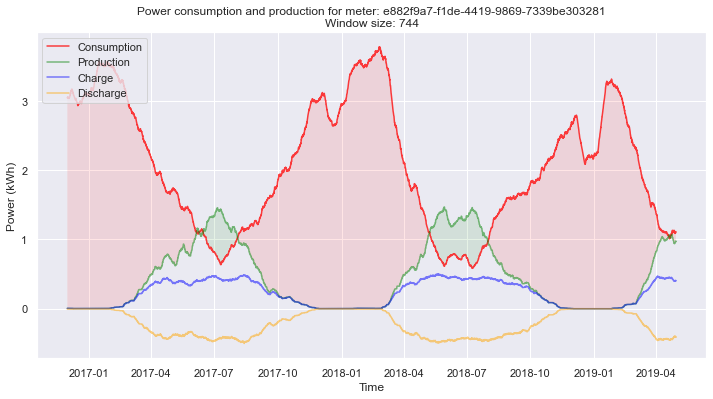

In [19]:
window_size = 24*31

series_battery["num_kwh_cons_ma"] = moving_average(series_battery["num_kwh_cons"], window=window_size)
series_battery["num_kwh_prod_ma"] = moving_average(series_battery["num_kwh_prod"], window=window_size)
series_battery["charge_ma"] = moving_average(series_battery["charge"], window=window_size)
series_battery["discharge_ma"] = moving_average(series_battery["discharge"], window=window_size)

sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery["timeslot"], series_battery["num_kwh_cons_ma"], label="Consumption", color="red", alpha=0.75)
ax.plot(series_battery["timeslot"], series_battery["num_kwh_prod_ma"], label="Production", color="green", alpha=0.5)
# ax.plot(series_battery["timeslot"], series_battery["surplus_deficit"], label="Surplus Deficit", alpha=0.75)

# Fill between positive
# ax.fill_between(series_merge["timeslot"], 0, series_merge["num_kwh_cons_ma"], where=series_merge["num_kwh_cons_ma"] >= 0, facecolor="green", alpha=0.5)
ax.fill_between(series_battery["timeslot"], series_battery["num_kwh_cons_ma"], series_battery["num_kwh_prod_ma"], where=series_battery["num_kwh_prod_ma"]>series_battery["num_kwh_cons_ma"], facecolor='green', alpha=0.1)
ax.fill_between(series_battery["timeslot"], series_battery["num_kwh_cons_ma"], series_battery["num_kwh_prod_ma"], where=series_battery["num_kwh_prod_ma"]<series_battery["num_kwh_cons_ma"], facecolor='red', alpha=0.1)

# x-axis label
ax.set_xlabel("Time")
# y-axis label
ax.set_ylabel("Power (kWh)")

# plot title    
ax.set_title("Power consumption and production for meter: " + meter_id + "\n" + "Window size: " + str(window_size))

# plot battery.charge_list as bar plot
# fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery["timeslot"], series_battery["charge_ma"], label="Charge", color="blue", alpha=0.5)
ax.plot(series_battery["timeslot"], series_battery["discharge_ma"], label="Discharge", color="orange", alpha=0.5)

# show legend
ax.legend(loc="upper left")

plt.show()

## Estimate cost with battery and with logic

if next hour's estimated cost is higher than our current - we wait discharging our battery

In [20]:
# Initialise battery
battery = Battery(max_capacity=12)

# Define logic 
def price_optimisation_logic(row, battery):

    power_yield = row["power_yield"]
    hour = row["timeslot"].hour


    # if hour is in peak hours we sell all the power we have and produce
    if hour in peak_hours:
        if power_yield >= 0:
            current_charge = battery.get_current_capacity()
            current_charge += power_yield
            battery.current_capacity = 0
            row["surplus_deficit"] = current_charge
        else:
            battery.charge(power_yield)
            surplus = battery.get_surplus_deficit()
            if surplus >= 0:
                remaining_capacity = battery.get_current_capacity()
                battery.current_capacity = 0
                row["surplus_deficit"] = remaining_capacity
            else:
                row["surplus_deficit"] = battery.get_surplus_deficit()
    else:
        if power_yield >= 0:
            battery.charge(power_yield)
            if battery.get_current_capacity() != battery.get_max_capacity():
                buy = -(battery.get_max_capacity() - battery.get_current_capacity())
                battery.current_capacity = battery.get_max_capacity()

                row["surplus_deficit"] = buy
            else:
                row["surplus_deficit"] = battery.get_surplus_deficit()

        else:
            row["surplus_deficit"] = power_yield - (battery.get_max_capacity() - battery.get_current_capacity())
    
    row["battery_capacity"] = battery.get_current_capacity()

    if battery.charge_list:
        row["charge"] = battery.charge_list[-1]
    else: 
        row["charge"] = 0
    
    
    if battery.charge_list:
        row["discharge"] = battery.discharge_list[-1]
    else: 
        row["discharge"] = 0
    return row

In [21]:
series_battery_logic = logic_rollout(series_merge.copy(), battery, price_optimisation_logic, get_price)

In [22]:
print_price_summary(series_battery_logic)

Cost for period: 2016-11-14 23:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  80433.0  NOK without VAT
Average cost per year is: 32251.0 NOK without VAT
Number of kwh purchased in the period: 137897.0
Average number of kwh purchased per year: 55292.521361266125


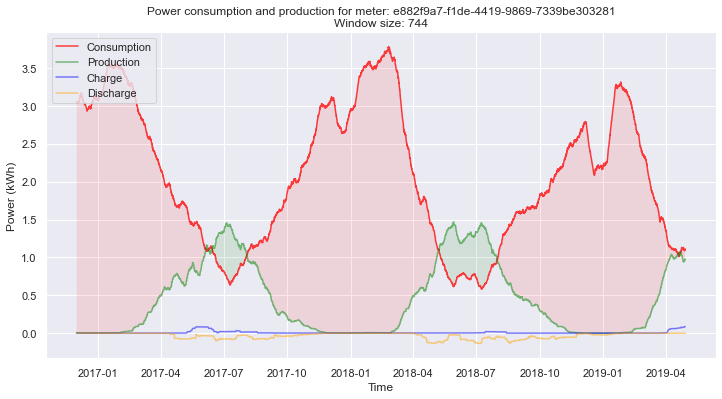

In [23]:
window_size = 24*31

series_battery_logic["num_kwh_cons_ma"] = moving_average(series_battery_logic["num_kwh_cons"], window=window_size)
series_battery_logic["num_kwh_prod_ma"] = moving_average(series_battery_logic["num_kwh_prod"], window=window_size)
series_battery_logic["charge_ma"] = moving_average(series_battery_logic["charge"], window=window_size)
series_battery_logic["discharge_ma"] = moving_average(series_battery_logic["discharge"], window=window_size)

sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery_logic["timeslot"], series_battery_logic["num_kwh_cons_ma"], label="Consumption", color="red", alpha=0.75)
ax.plot(series_battery_logic["timeslot"], series_battery_logic["num_kwh_prod_ma"], label="Production", color="green", alpha=0.5)
# ax.plot(series_battery["timeslot"], series_battery["surplus_deficit"], label="Surplus Deficit", alpha=0.75)

# Fill between positive
# ax.fill_between(series_merge["timeslot"], 0, series_merge["num_kwh_cons_ma"], where=series_merge["num_kwh_cons_ma"] >= 0, facecolor="green", alpha=0.5)
ax.fill_between(series_battery_logic["timeslot"], series_battery_logic["num_kwh_cons_ma"], series_battery_logic["num_kwh_prod_ma"], where=series_battery_logic["num_kwh_prod_ma"]>series_battery_logic["num_kwh_cons_ma"], facecolor='green', alpha=0.1)
ax.fill_between(series_battery_logic["timeslot"], series_battery_logic["num_kwh_cons_ma"], series_battery_logic["num_kwh_prod_ma"], where=series_battery_logic["num_kwh_prod_ma"]<series_battery_logic["num_kwh_cons_ma"], facecolor='red', alpha=0.1)

# x-axis label
ax.set_xlabel("Time")
# y-axis label
ax.set_ylabel("Power (kWh)")

# plot title    
ax.set_title("Power consumption and production for meter: " + meter_id + "\n" + "Window size: " + str(window_size))

# plot battery.charge_list as bar plot
# fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery_logic["timeslot"], series_battery_logic["charge_ma"], label="Charge", color="blue", alpha=0.5)
ax.plot(series_battery_logic["timeslot"], series_battery_logic["discharge_ma"], label="Discharge", color="orange", alpha=0.5)

# show legend
ax.legend(loc="upper left")

plt.show()

# Tariff optimisation

Define logic and battery

In [24]:
# Initialise battery
battery = Battery(max_capacity=12)

# Define logic 
def tariff_optimisation_logic(row, battery):

    power_yield = row["power_yield"]
    hour = row["timeslot"].hour
    deficit = power_yield < 0


    # If production
    if power_yield >= 0:
        # Charge battery with surplus
        battery.charge(power_yield)


    # If we are in peak hours
    if hour in peak_hours:
        # Discharge battery if deficit
        if deficit:
            battery.charge(power_yield)
    else: 

        # Initialise power_to_buy to 0
        power_to_buy = 0
        # If battery is not fully charged 
        if battery.get_current_capacity() != battery.get_max_capacity():
            # Charge battery
            power_to_buy = battery.get_max_capacity() - battery.get_current_capacity()
            battery.charge(power_to_buy) 


        if deficit: 
            if deficit:
                battery.surplus_deficit = -power_to_buy + power_yield
            else: 
                battery.surplus_deficit = -power_to_buy


    row["surplus_deficit"] = battery.get_surplus_deficit()
    row["battery_capacity"] = battery.get_current_capacity()
    row["charge"] = battery.charge_list[-1]
    row["discharge"] = battery.discharge_list[-1]

    return row

In [25]:
series_battery_logic_TO = logic_rollout(series_merge.copy(), battery, tariff_optimisation_logic, get_price)

Print price summary

In [26]:
print_price_summary(series_battery_logic_TO)

Cost for period: 2016-11-14 23:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  24138.0  NOK without VAT
Average cost per year is: 9679.0 NOK without VAT
Number of kwh purchased in the period: 35534.0
Average number of kwh purchased per year: 14248.058000182966


Plot  

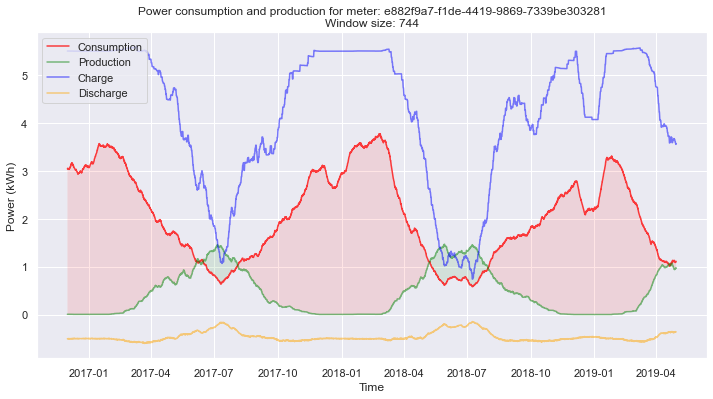

In [27]:
# Smooth data
window_size = 24*31

series_battery_logic_TO["num_kwh_cons_ma"] = moving_average(series_battery_logic_TO["num_kwh_cons"], window=window_size)
series_battery_logic_TO["num_kwh_prod_ma"] = moving_average(series_battery_logic_TO["num_kwh_prod"], window=window_size)
series_battery_logic_TO["charge_ma"] = moving_average(series_battery_logic_TO["charge"], window=window_size)
series_battery_logic_TO["discharge_ma"] = moving_average(series_battery_logic_TO["discharge"], window=window_size)

# num_kwh_cons_ma = moving_average(series_merge["num_kwh_cons"], window=24)
sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery_logic_TO["timeslot"], series_battery_logic_TO["num_kwh_cons_ma"], label="Consumption", color="red", alpha=0.75)
ax.plot(series_battery_logic_TO["timeslot"], series_battery_logic_TO["num_kwh_prod_ma"], label="Production", color="green", alpha=0.5)
# ax.plot(series_battery["timeslot"], series_battery["surplus_deficit"], label="Surplus Deficit", alpha=0.75)

# Fill between positive
# ax.fill_between(series_merge["timeslot"], 0, series_merge["num_kwh_cons_ma"], where=series_merge["num_kwh_cons_ma"] >= 0, facecolor="green", alpha=0.5)
ax.fill_between(series_battery_logic_TO["timeslot"], series_battery_logic_TO["num_kwh_cons_ma"], series_battery_logic_TO["num_kwh_prod_ma"], where=series_battery_logic_TO["num_kwh_prod_ma"]>series_battery_logic_TO["num_kwh_cons_ma"], facecolor='green', alpha=0.1)
ax.fill_between(series_battery_logic_TO["timeslot"], series_battery_logic_TO["num_kwh_cons_ma"], series_battery_logic_TO["num_kwh_prod_ma"], where=series_battery_logic_TO["num_kwh_prod_ma"]<series_battery_logic_TO["num_kwh_cons_ma"], facecolor='red', alpha=0.1)

# x-axis label
ax.set_xlabel("Time")
# y-axis label
ax.set_ylabel("Power (kWh)")

# plot title    
ax.set_title("Power consumption and production for meter: " + meter_id + "\n" + "Window size: " + str(window_size))

# plot battery.charge_list as bar plot
# fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery_logic_TO["timeslot"], series_battery_logic_TO["charge_ma"], label="Charge", color="blue", alpha=0.5)
ax.plot(series_battery_logic_TO["timeslot"], series_battery_logic_TO["discharge_ma"], label="Discharge", color="orange", alpha=0.5)

# show legend
ax.legend(loc="upper left")
plt.show()

##  DP optimized path

In [28]:
# Initialise battery
battery = Battery(max_capacity=12)

actions = pd.read_csv("actions_small_graph_mulitplied_peak.txt", sep=",", header=None)
# convert to list
actions = actions.values.tolist()[0]

# Define logic 
def DP_logic(row, battery):

    u =  actions.pop(0)
    # u = 1

    battery.charge(u)
    row["surplus_deficit"] = row["power_yield"] - u

    # row["surplus_deficit"] = battery.get_surplus_deficit()
    row["battery_capacity"] = battery.get_current_capacity()
    row["charge"] = battery.charge_list[-1]
    row["discharge"] = battery.discharge_list[-1]
    
    return row

In [29]:
series_battery_logic_DP = logic_rollout(series_merge.copy(), battery, DP_logic, get_price)

In [30]:
print_price_summary(series_battery_logic_DP)

Cost for period: 2016-11-14 23:00:00+00:00 to 2019-05-14 21:00:00+00:00 is:  24877.0  NOK without VAT
Average cost per year is: 9975.0 NOK without VAT
Number of kwh purchased in the period: 35549.0
Average number of kwh purchased per year: 14254.072545970175


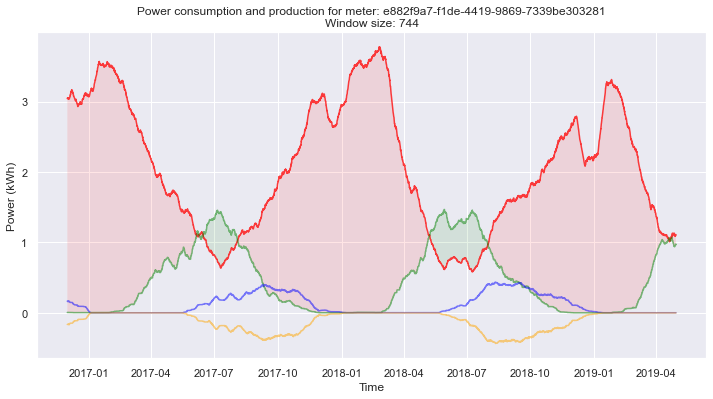

In [31]:
# Smooth data
window_size = 24*31

series_battery_logic_DP["num_kwh_cons_ma"] = moving_average(series_battery_logic_DP["num_kwh_cons"], window=window_size)
series_battery_logic_DP["num_kwh_prod_ma"] = moving_average(series_battery_logic_DP["num_kwh_prod"], window=window_size)
series_battery_logic_DP["charge_ma"] = moving_average(series_battery_logic_DP["charge"], window=window_size)
series_battery_logic_DP["discharge_ma"] = moving_average(series_battery_logic_DP["discharge"], window=window_size)

# num_kwh_cons_ma = moving_average(series_merge["num_kwh_cons"], window=24)
sns.set()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery_logic_DP["timeslot"], series_battery_logic_DP["num_kwh_cons_ma"], label="Consumption", color="red", alpha=0.75)
ax.plot(series_battery_logic_DP["timeslot"], series_battery_logic_DP["num_kwh_prod_ma"], label="Production", color="green", alpha=0.5)
# ax.plot(series_battery["timeslot"], series_battery["surplus_deficit"], label="Surplus Deficit", alpha=0.75)

# Fill between positive
# ax.fill_between(series_merge["timeslot"], 0, series_merge["num_kwh_cons_ma"], where=series_merge["num_kwh_cons_ma"] >= 0, facecolor="green", alpha=0.5)
ax.fill_between(series_battery_logic_DP["timeslot"], series_battery_logic_DP["num_kwh_cons_ma"], series_battery_logic_DP["num_kwh_prod_ma"], where=series_battery_logic_DP["num_kwh_prod_ma"]>series_battery_logic_DP["num_kwh_cons_ma"], facecolor='green', alpha=0.1)
ax.fill_between(series_battery_logic_DP["timeslot"], series_battery_logic_DP["num_kwh_cons_ma"], series_battery_logic_DP["num_kwh_prod_ma"], where=series_battery_logic_DP["num_kwh_prod_ma"]<series_battery_logic_DP["num_kwh_cons_ma"], facecolor='red', alpha=0.1)

ax.set_title("Power consumption and production for meter: " + meter_id + "\n" + "Window size: " + str(window_size))


# plot battery.charge_list as bar plot
# fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(series_battery_logic_DP["timeslot"], series_battery_logic_DP["charge_ma"], label="Charge", color="blue", alpha=0.5)
ax.plot(series_battery_logic_DP["timeslot"], series_battery_logic_DP["discharge_ma"], label="Discharge", color="orange", alpha=0.5)

# x-axis label
ax.set_xlabel("Time")
# y-axis label
ax.set_ylabel("Power (kWh)")

plt.show()

# Plot cummulative price 

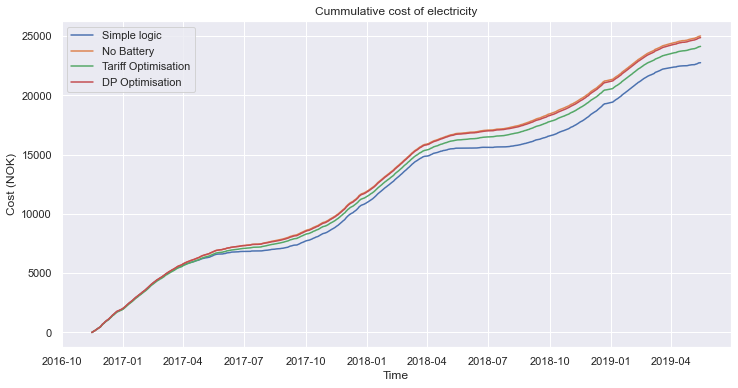

In [32]:
# plot cummulative price
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(series_battery_logic["timeslot"], series_battery_logic["price_cummulative"], label="Shitty logic")
ax.plot(series_battery["timeslot"], series_battery["price_cummulative"], label="Simple logic")
ax.plot(series_no_battery["timeslot"], series_no_battery["price_cummulative"], label="No Battery")
ax.plot(series_battery_logic_TO["timeslot"], series_battery_logic_TO["price_cummulative"], label="Tariff Optimisation")
ax.plot(series_battery_logic_DP["timeslot"], series_battery_logic_DP["price_cummulative"], label="DP Optimisation")

ax.set_xlabel('Time')
ax.set_ylabel('Cost (NOK)')
ax.set_title('Cummulative cost of electricity')

ax.legend()
plt.show()


## Savings percentage barplot

{'Simple logic': 9.023039946978708, 'Shitty logic': -221.52312776730892, 'Tariff optimisation': 3.509306362885383, 'DP optimisation': 0.5573035165195903}


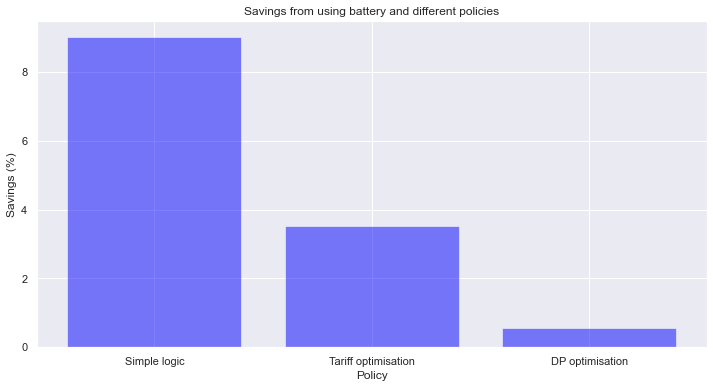

In [40]:
series_list = {"Simple logic": series_battery, "Shitty logic": series_battery_logic, "Tariff optimisation": series_battery_logic_TO, "DP optimisation": series_battery_logic_DP}

savings_percentage_dict = {}

# Create a savings percentage dictionary
for name, series in series_list.items():
    series_price_sum = series["price"].sum()
    series_no_battery_price_sum = series_no_battery["price"].sum()
    savings_percentage = ((series_no_battery_price_sum-series_price_sum)/series_no_battery_price_sum)*100
    savings_percentage_dict[name] = savings_percentage
print(savings_percentage_dict)


# Drop "shitty logic" from savings_percentage_dict dict
del savings_percentage_dict["Shitty logic"]


# plot barplot of savings_percentage_dict
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(list(savings_percentage_dict.keys()), list(savings_percentage_dict.values()), color="blue", alpha=0.5)
ax.set_xlabel('Policy')
ax.set_ylabel('Savings (%)')
ax.set_title('Savings from using battery and different policies')
plt.show()


# Rolling window with forecast

In [113]:
def chunks(df, n):
    """Make chunks 

    Args:
        df (DataFrame): pandas dataframe to split into chunks
        n (int): chunk size

    Yields:
        DataFrame: Chunks of dataframe
    """
    for i in range(0, df.shape[0], n):
        yield df.iloc[i:i + n]

In [114]:
# load RF_prediction_consumption.csv
RF_prediction_consumption = pd.read_csv("data/RF_prediction_consumption.csv")
RF_prediction_production = pd.read_csv("data/RF_prediction_production.csv")

# Convert to datetime
RF_prediction_consumption.index = pd.to_datetime(RF_prediction_consumption["timeslot"], utc = True)
RF_prediction_production.index = pd.to_datetime(RF_prediction_production["timeslot"], utc = True)

# sort by index
RF_prediction_consumption = RF_prediction_consumption.sort_index()
RF_prediction_production = RF_prediction_production.sort_index()

In [177]:
orig_data = series_merge.copy()
orig_data.index = pd.to_datetime(orig_data["timeslot"], utc = True)

# drop columns from orig_data
orig_data = orig_data.drop(["num_kwh_cons_ma", "num_kwh_prod_ma", "timeslot"], axis=1)
orig_data.columns = ["num_kwh_prod_orig", "num_kwh_cons_orig", "power_yield_orig"]


,num_kwh_prod_orig,num_kwh_cons_orig,power_yield_orig
timeslot,,,
2016-11-14 23:00:00+00:00,0.000,1.000,-1.000
2016-11-15 00:00:00+00:00,0.000,3.000,-3.000
2016-11-15 01:00:00+00:00,0.000,2.000,-2.000
2016-11-15 02:00:00+00:00,0.000,2.000,-2.000
2016-11-15 03:00:00+00:00,0.000,1.000,-1.000
...,...,...,...
2019-05-14 17:00:00+00:00,0.031,0.000,0.031
2019-05-14 18:00:00+00:00,0.000,2.329,-2.329
2019-05-14 19:00:00+00:00,0.000,4.054,-4.054


In [181]:
# Merge RF_prediction_consumption and RF_prediction_production
RF_prediction_consumption_and_production = RF_prediction_consumption.merge(RF_prediction_production, how="inner", left_index=True, right_index=True)


RF_prediction_consumption_and_production.columns = ["timeslot_cons", "pred_cons", "lower_bound_cons", "upper_bound_cons", "timeslot_prod", "pred_prod", "lower_bound_prod", "upper_bound_prod"]
# drop timeslot column
RF_prediction_consumption_and_production.drop(["timeslot_cons", "timeslot_prod"], axis=1, inplace=True)

# Merge with series_merge
RF_prediction_consumption_and_production = RF_prediction_consumption_and_production.merge(orig_data, how="inner", left_index=True, right_index=True)
# RF_prediction_consumption_and_production_and_series_merge


# Add column called power_yield with the difference between prod and cons
RF_prediction_consumption_and_production["power_yield"] = RF_prediction_consumption_and_production["pred_prod"] - RF_prediction_consumption_and_production["pred_cons"]
# add column current index as timeslot and reset index
RF_prediction_consumption_and_production["timeslot"] = RF_prediction_consumption_and_production.index
RF_prediction_consumption_and_production = RF_prediction_consumption_and_production.reset_index(drop=True)

RF_prediction_consumption_and_production.head()

,pred_cons,lower_bound_cons,upper_bound_cons,pred_prod,lower_bound_prod,upper_bound_prod,num_kwh_prod_orig,num_kwh_cons_orig,power_yield_orig,power_yield,timeslot
0,0.000444,-0.023711,0.047452,0.055218,0.015114,0.114701,0.0,1.0,-1.0,0.054774,2017-09-04 22:00:00+00:00
1,0.000444,-0.022775,0.044722,0.060391,0.000900,0.109158,0.0,1.0,-1.0,0.059947,2017-09-04 23:00:00+00:00
2,0.000444,-0.023344,0.053240,0.048054,-0.004446,0.104350,0.0,1.0,-1.0,0.047610,2017-09-05 00:00:00+00:00
3,0.000444,-0.017118,0.043948,0.050401,-0.001684,0.096851,0.0,1.0,-1.0,0.049957,2017-09-05 01:00:00+00:00
4,0.000444,-0.016349,0.055556,0.048071,-0.002628,0.110221,0.0,1.0,-1.0,0.047627,2017-09-05 02:00:00+00:00


In [209]:

# Define battery with capcacity 0, same as no battery
# no_battery = Battery(0)
battery_simple_logic = Battery(12)
battery_TO_logic = Battery(12)

battery_real = Battery(12)

i = 0

best_choice = []
real_cost = []
for chunk in chunks(RF_prediction_consumption_and_production, 24):

    # rollout_series_no_battery = logic_rollout(chunk.copy(), no_battery, logic, get_price)
    rollout_series_simple_logic = logic_rollout(chunk.copy(), battery_simple_logic, logic, get_price)
    rollout_series_logic_TO = logic_rollout(chunk.copy(), battery_TO_logic, tariff_optimisation_logic, get_price)

    # get price summary
    # price_summary_no_battery = rollout_series_no_battery["price"].sum()
    price_summary_simple_logic = rollout_series_simple_logic["price"].sum()
    price_summary_simple_logic_TO = rollout_series_logic_TO["price"].sum()

    # print(np.argmin([price_summary_simple_logic, price_summary_simple_logic_TO]))
    # print(price_summary_simple_logic, price_summary_simple_logic_TO)
    best = np.argmin([price_summary_simple_logic, price_summary_simple_logic_TO])
    best_choice.append(best)


    if best == 0:
        c = chunk[["num_kwh_prod_orig", "num_kwh_cons_orig", "power_yield_orig", "timeslot"]].copy()
        c.columns = ["num_kwh_prod", "num_kwh_cons", "power_yield", "timeslot"]
        rollout = logic_rollout(c, battery_real, logic, get_price)
        # print(rollout)
        # print(chunk)

        real_cost.append(rollout["price"].sum())
    elif best == 1:
        c = chunk[["num_kwh_prod_orig", "num_kwh_cons_orig", "power_yield_orig", "timeslot"]].copy()
        c.columns = ["num_kwh_prod", "num_kwh_cons", "power_yield", "timeslot"]
        rollout = logic_rollout(c, battery_real, tariff_optimisation_logic, get_price)
        # print(rollout)
        # print(chunk)
        rollout_series_simple_logic["price"].sum()
        real_cost.append(rollout["price"].sum())

    # break

    i += 1 
    if i % 100 == 0:
        print("Iteration: ", i)

Iteration:  100
Iteration:  200
Iteration:  300
Iteration:  400
Iteration:  500
Iteration:  600


In [214]:
sum(real_cost)

15996.235658166448